In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

In [2]:
sns.set_style("whitegrid")

In [3]:
col_names = ["date", "value"]
df = pd.read_csv("Electric_Production.csv", names=col_names, header=0)

In [4]:
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])

# EDA

## Analysis of the data

**Identification of the target data**

In [5]:
df.columns

Index(['value'], dtype='object')

The problem to solve is a forecasting problem, so there is not a target variable. The data to predict is the electricity consumption.

**Number of rows and columns**

In [6]:
df.columns.value_counts().sum()

1

In [7]:
df.count()[0]

397

There are 397 rows and 2 columns.

**Types of variables**

In [8]:
df.dtypes.value_counts()

float64    1
dtype: int64

There is 1 variable of type `object` and 1 variable of type `float64`.

The variable `date` is of type `object` and the variable `value` is of type `float64`.

**Missing values**

In [9]:
df.isna().sum().sum()

0

There are no missing values in the dataset.

**Data visualization**

In [10]:
%matplotlib inline

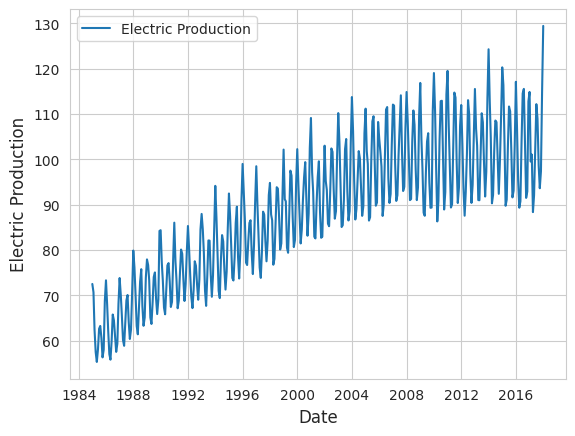

In [13]:
plt.plot(df,label="Electric Production")
plt.xlabel("Date",size = 12)
plt.ylabel("Electric Production",size=12)
# plt.xticks(np.arange(0, len(df), step=36), df["date"][::36], rotation=45)
plt.legend();

The time series oscillates a lot, to better visualize the data, we will perform a rolling window

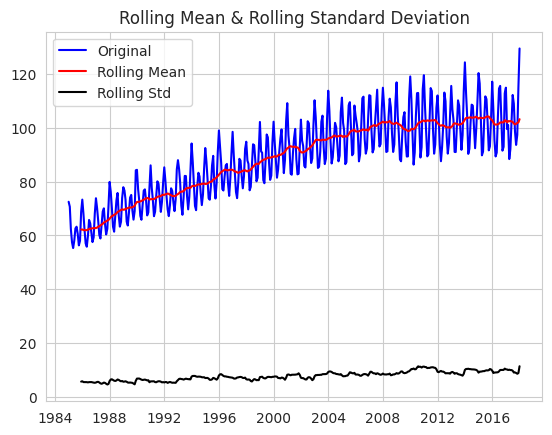

In [15]:
rolling_mean = df["value"].rolling(window=12).mean()
rolling_std = df["value"].rolling(window=12).std()
plt.plot(df, color='blue',label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show();

The moving average seems to indicate that the time series is not stationary, so we will perform the Dickey-Fuller test to confirm this.
Let's formulate our hypothesis:

* $H_0$: The time series is not stationary
* $H_1$: The time series is stationary

In [16]:
# perform Dickey-Fuller test
result = adfuller(df["value"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.256990
p-value: 0.186215
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


The p-value is approximatively 0.186, so we can't reject the null hypothesis. The time series is not stationary.

## Box-cox transformation

The Box-Cox transformation is a family of power transformations indexed by a parameter $\lambda$. For $\lambda = 0$, the natural logarithm of the data is taken instead of using the general power transformation. The transformation is given by:

$$
y(\lambda) = \begin{cases}
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(y) & \text{if } \lambda = 0
\end{cases}
$$

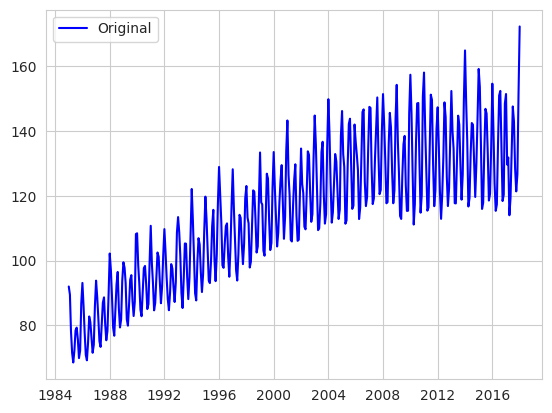

In [17]:
df_log = df.copy()
df_log["value"] = boxcox(df_log["value"])[0]

plt.plot(df_log, color='blue',label='Original')
plt.legend(loc='best')
plt.show();

## Removing trend

Later, we will train an ARIMA model, so we need to remove the trend from the time series. We will substract the moving average from the time series.

In [18]:
moving_avg = df_log["value"].rolling(window=12).mean()
df_log_movavg = df_log.copy()
df_log_movavg["value"] = df_log["value"] - moving_avg
print(df_log_movavg["value"].isna().sum())
df_log_movavg.dropna(inplace=True)

11


Due to the moving average, the first 11 values are NaN, they have been removed.

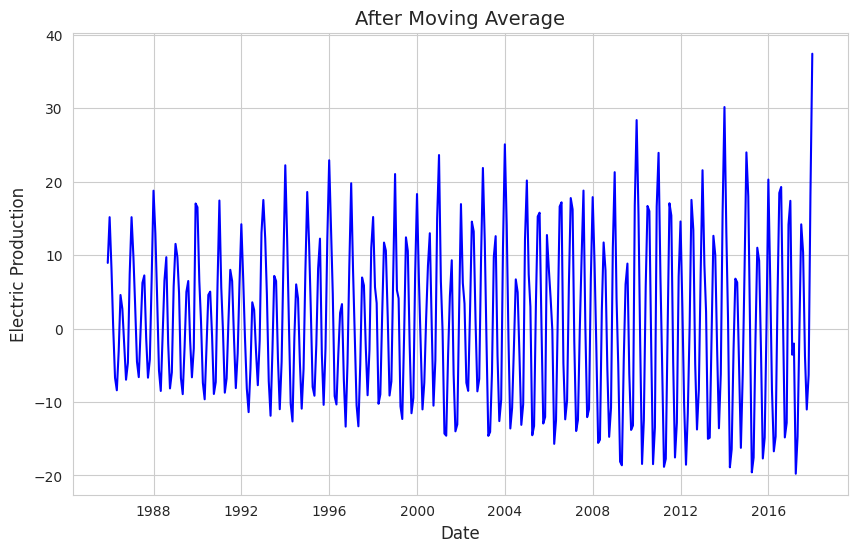

In [19]:
plt.figure(figsize = (10,6))
plt.plot(df_log_movavg, color = 'blue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

# Exponential smoothing

We want to give more importance to the most recent values, so we will use the exponential smoothing method.

In [20]:
df_log_movavg

,value
date,
1985-12-01,8.930025
1986-01-01,15.154401
1986-02-01,8.147204
1986-03-01,0.293642
1986-04-01,-6.703120
...,...
2017-09-01,-3.736500
2017-10-01,-11.024006
2017-11-01,-6.309421


In [21]:
df_log_movavg_exp_decay = df_log_movavg.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_movavg_exp_decay_diff = df_log_movavg.copy()
df_log_movavg_exp_decay_diff["value"] = df_log_movavg["value"] - df_log_movavg_exp_decay["value"]

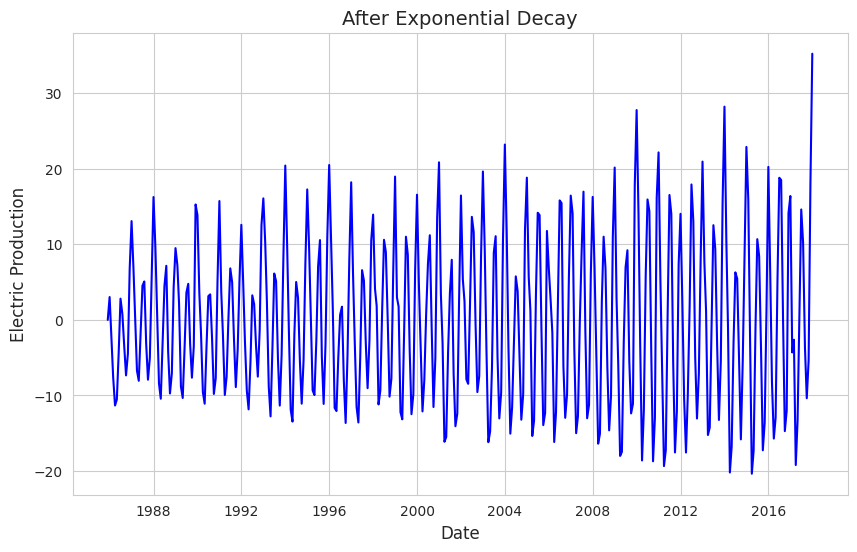

In [23]:
plt.figure(figsize = (10,6))
plt.plot(df_log_movavg_exp_decay_diff, color = 'blue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Exponential Decay", size = 14)
plt.show()

Now the time series is stationary, we can verify it with another Dickey-Fuller test. Our hypothesis are:

* $H_0$: The time series is not stationary
* $H_1$: The time series is stationary

In [24]:
result = adfuller(df_log_movavg_exp_decay_diff["value"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.293557
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


The p-value is below the threshold of 0.01, we can reject the null hypothesis. The time series is stationary.

## Additive decomposition

The time series can be decomposed into 3 components: trend, seasonality and noise. We will use the additive decomposition.

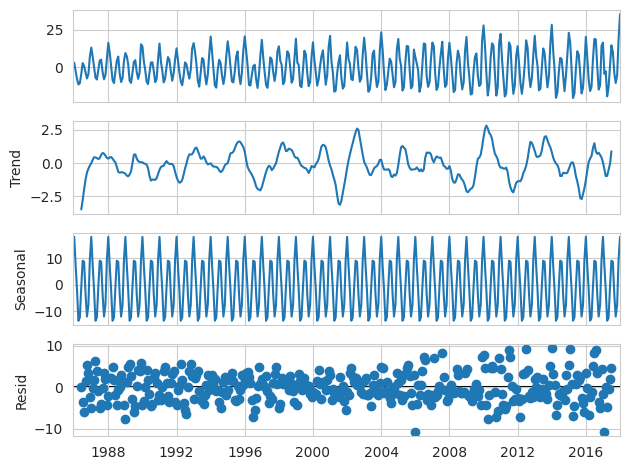

In [25]:
df_seasonal_decompose = seasonal_decompose(df_log_movavg_exp_decay_diff, model='additive')
df_seasonal_decompose.plot()
plt.show()

## Autocorrelation

To identify seasonal patterns, we will plot the autocorrelation function.

It will also help us to identify the parameters of the ARIMA model.

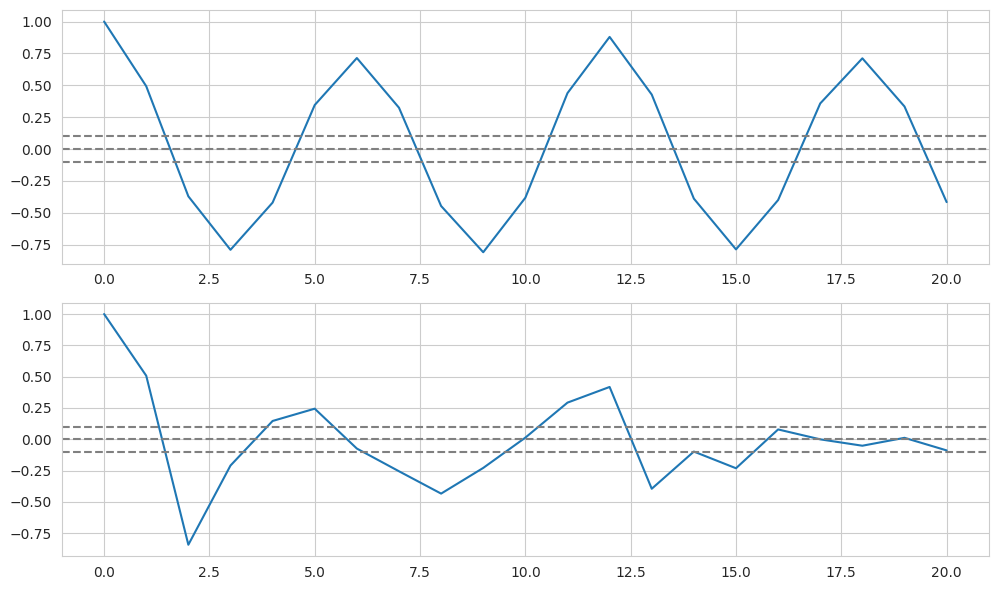

In [26]:
auto_corr = acf(df_log_movavg_exp_decay_diff["value"], nlags=20)
partial_auto_corr = pacf(df_log_movavg_exp_decay_diff["value"], nlags=20, method='ols')

plt.figure(figsize = (10,6))
plt.subplot(211)
plt.plot(auto_corr)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_movavg_exp_decay_diff["value"])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_movavg_exp_decay_diff["value"])),linestyle='--',color='gray')

plt.subplot(212)
plt.plot(partial_auto_corr)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_movavg_exp_decay_diff["value"])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_movavg_exp_decay_diff["value"])),linestyle='--',color='gray')

plt.tight_layout()
plt.show()

There is a repeating pattern every 6 lags.

# Model training

For the forecasting models, we will train 3 models:

* Naive model
* AR model
* ARIMA model

The naive model is the simplest model, it predicts the next value as the last value of the time series.

**Naive model**

First we need to split the data into a training set and a test set. The test set will be the last 10 values of the time series.

In [31]:
values = pd.DataFrame(df_log_movavg_exp_decay_diff.values)
persistence_df = pd.concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

train = per_values[1:len(per_values)-10] 
test = per_values[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

This model doesn't need to be trained, we can just create function that returns itself

In [33]:
def model_persistence(x):
    return x

pred = []
for x in X_test:
    yhat = model_persistence(x)
    pred.append(yhat)

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 13.502


Let's compare the data with the naive model.

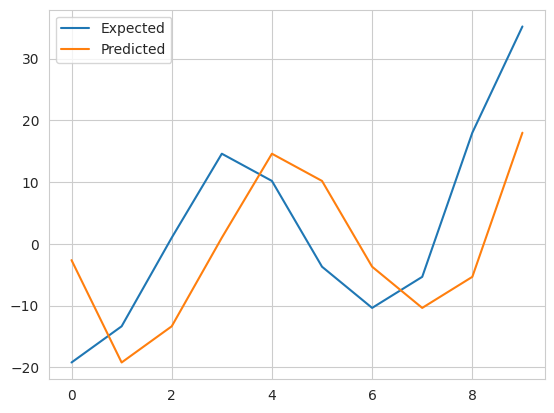

In [34]:
plt.plot(y_test, label='Expected')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

**AR model**

The AR model stands for AutoRegressive model. It is a model that uses the dependent relationship between an observation and some number of lagged observations.

In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
ar_values = df_log_movavg_exp_decay_diff.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

In [41]:
predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
mse = mean_squared_error(test, predictions)
mse

/home/sacha/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


445.6067209321047

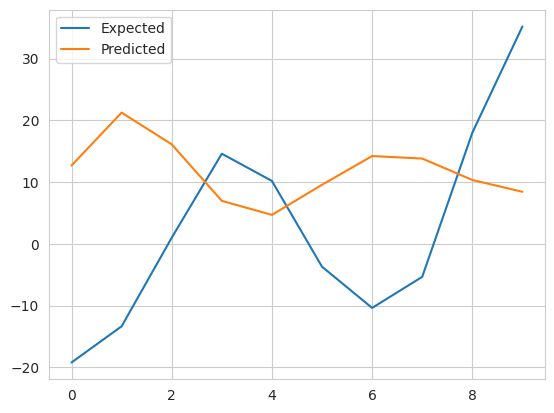

In [42]:
plt.plot(test, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

**ARIMA model**

Now, we will change the parameter of the AR model to an ARIMA model. The ARIMA model stands for AutoRegressive Integrated Moving Average model. It is a generalization of an autoregressive moving average model.

In [43]:
ar_values = df_log_movavg_exp_decay_diff.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(2,1,2))
AR_model = model.fit()

In [44]:
predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
mse = mean_squared_error(test, predictions)
mse

/home/sacha/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


58.26669162559277

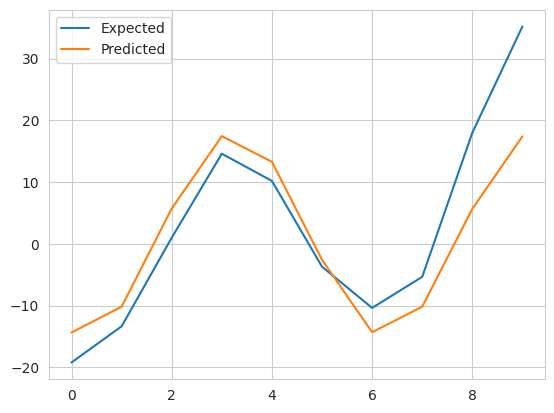

In [45]:
plt.plot(test, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()